In [23]:
# OS → to work with folders and file paths
import os

# OpenCV → to read and resize MRI images
import cv2
import joblib
# NumPy → to store images as numerical arrays
import numpy as np

import pandas as pd

# Matplotlib → to visualise images and plots
import matplotlib.pyplot as plt



In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


In [3]:
# Path to the dataset folder containing MRI images
dataset_path = "parkinsons_dataset"

# Two classes for binary classification
# normal → label 0
# parkinson → label 1
classes = ["normal", "parkinson"]


In [4]:
# Loop through each class folder and count images
# This helps identify dataset size and class imbalance

for cls in classes:
    path = os.path.join(dataset_path, cls)
    print(cls, "→", len(os.listdir(path)), "images")
# Loop through each class folder and count images
# This helps identify dataset size and class imbalance



normal → 610 images
parkinson → 221 images


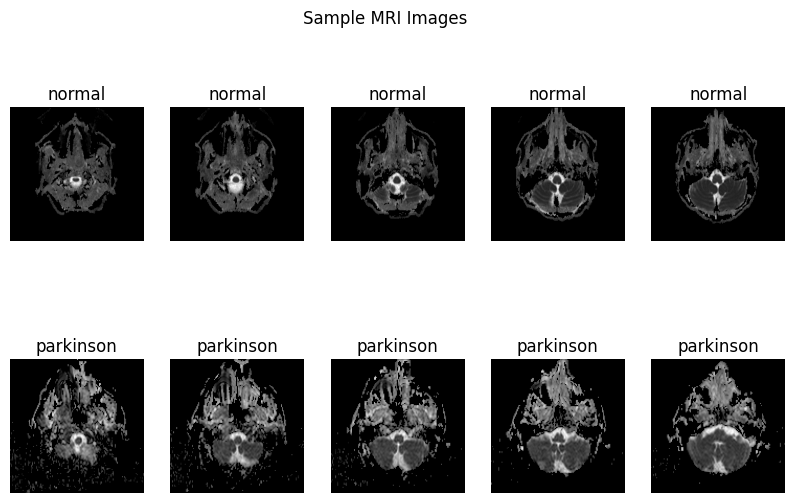

In [5]:
# Display a few MRI images from each class
# This is a sanity check to ensure images are correct and readable

plt.figure(figsize=(10,6))

for i, cls in enumerate(classes):
    folder = os.path.join(dataset_path, cls)
    
    # Take first 5 images from each class
    images = os.listdir(folder)[:5]
    
    for j, img_name in enumerate(images):
        img_path = os.path.join(folder, img_name)
        
        # Read image in grayscale (MRI scans are intensity-based)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Arrange images in a 2×5 grid
        plt.subplot(2, 5, i*5 + j + 1)
        plt.imshow(img, cmap="gray")
        plt.title(cls)
        plt.axis("off")

plt.suptitle("Sample MRI Images")
plt.show()


In [6]:
# Store all image shapes to understand size variability
shapes = []

for cls in classes:
    folder = os.path.join(dataset_path, cls)
    
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Only store shape if image is successfully read
        if img is not None:
            shapes.append(img.shape)

# Display unique image dimensions
set(shapes)


{(128, 128),
 (192, 192),
 (256, 232),
 (256, 256),
 (320, 250),
 (320, 260),
 (448, 364),
 (512, 512),
 (560, 560)}

In [7]:
# Count how many corrupted images are removed
removed = 0

for cls in classes:
    folder = os.path.join(dataset_path, cls)
    
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        
        # Read image normally
        img = cv2.imread(img_path)
        
        # If image cannot be read, remove it
        if img is None:
            os.remove(img_path)
            removed += 1

print("Corrupted images removed:", removed)


Corrupted images removed: 0


In [8]:
# Standard image size for all MRI scans
IMG_SIZE = 128

# X → image data
# y → corresponding labels
X = []
y = []

# Loop through each class
for label, cls in enumerate(classes):
    folder = os.path.join(dataset_path, cls)
    
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        
        # Read MRI in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Resize to fixed dimensions
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        
        # Normalize pixel values from [0,255] → [0,1]
        img = img / 255.0
        
        # Store processed image and label
        X.append(img)
        y.append(label)

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (831, 128, 128)
y shape: (831,)


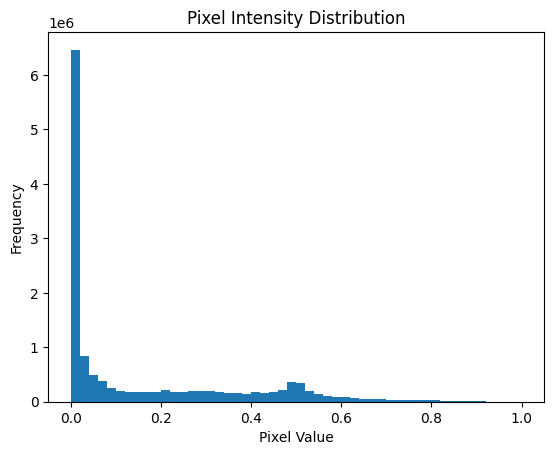

In [9]:
# Flatten all pixel values and plot distribution
# Helps understand MRI intensity characteristics

plt.hist(X.flatten(), bins=50)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


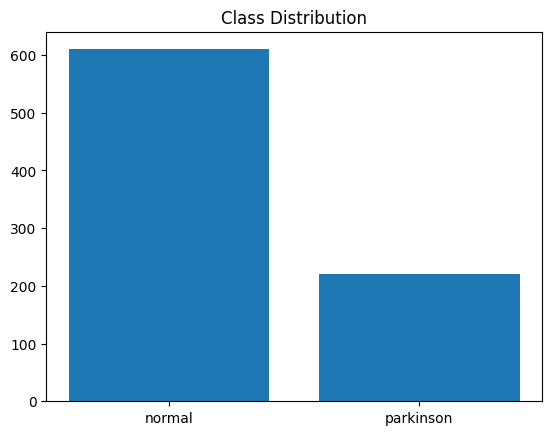

In [10]:
# Count samples per class
unique, counts = np.unique(y, return_counts=True)

# Plot class imbalance
plt.bar(["normal", "parkinson"], counts)
plt.title("Class Distribution")
plt.show()


In [11]:
# Save processed data to avoid re-running preprocessing
np.save("X_clean.npy", X)
np.save("y_clean.npy", y)

# Reload example (optional)
X = np.load("X_clean.npy")
y = np.load("y_clean.npy")


In [12]:
# Classical ML models (like SVM, Logistic Regression)
# cannot work directly with 2D images.
# So we convert each 128x128 image → 1D vector of length 16384.

X_flat = X.reshape(X.shape[0], -1)

print("Original X shape:", X.shape)
print("Flattened X shape:", X_flat.shape)

#Each image becomes one row
#Each pixel becomes one feature


Original X shape: (831, 128, 128)
Flattened X shape: (831, 16384)


In [13]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
# stratify=y ensures class ratio is preserved in both sets

X_train, X_test, y_train, y_test = train_test_split(
    X_flat,
    y,
    test_size=0.2,      # 80% train, 20% test
    random_state=42,    # reproducibility
    stratify=y          # VERY important for imbalanced medical data
)

print("Training data:", X_train.shape, y_train.shape)
print("Testing data :", X_test.shape, y_test.shape)


Training data: (664, 16384) (664,)
Testing data : (167, 16384) (167,)


In [14]:
from sklearn.svm import SVC

# Support Vector Machine with RBF kernel
# RBF handles non-linear MRI patterns
# class_weight balances normal vs parkinson classes

svm = SVC(
    kernel="rbf",
    class_weight="balanced",
    probability=True
)

# Train the model
svm.fit(X_train, y_train)


SVC(class_weight='balanced', probability=True)

In [15]:
# Predict labels for test data
y_pred = svm.predict(X_test)


In [16]:
from sklearn.metrics import accuracy_score, classification_report

# Overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Detailed metrics: precision, recall, f1-score
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9640718562874252

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       123
           1       0.93      0.93      0.93        44

    accuracy                           0.96       167
   macro avg       0.95      0.95      0.95       167
weighted avg       0.96      0.96      0.96       167



In [17]:
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC

model = SVC(kernel="rbf", C=1, gamma="scale")
model.fit(X_train, y_train)



# Predictions
y_train_pred = model.predict(X_train)
y_test_pred  = model.predict(X_test)

# Accuracies
train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test, y_test_pred)



print("Training Accuracy:", train_acc)
print("Testing Accuracy :", test_acc)
print("Gap (Train - Test):", train_acc - test_acc)




Training Accuracy: 0.983433734939759
Testing Accuracy : 0.9700598802395209
Gap (Train - Test): 0.013373854700238108


In [18]:

if train_acc - test_acc > 0.05:
    print("Model is OVERFITTING")
else:
    print("Model is NOT overfitting")


Model is NOT overfitting


In [19]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    model,
    X_flat,     # full dataset
    y,
    cv=5,       # 5-fold cross-validation
    scoring="accuracy"
)

print("Cross-validation accuracies:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())


Cross-validation accuracies: [0.7005988  0.94578313 0.96987952 0.65060241 0.8313253 ]
Mean CV accuracy: 0.8196378327681986


In [20]:
# Initialise counts
TP = FP = TN = FN = 0

# Loop through true labels and predicted labels
for actual, predicted in zip(y_test, y_pred):
    if actual == 1 and predicted == 1:
        TP += 1
    elif actual == 0 and predicted == 1:
        FP += 1
    elif actual == 0 and predicted == 0:
        TN += 1
    elif actual == 1 and predicted == 0:
        FN += 1

# Sanity check
TP, FP, TN, FN


(41, 3, 120, 3)

In [21]:
# Create truth table as DataFrame
truth_table = pd.DataFrame(
    [[TN, FP],
     [FN, TP]],
    index=["Actual Normal", "Actual Parkinson"],
    columns=["Predicted Normal", "Predicted Parkinson"]
)

truth_table


,Predicted Normal,Predicted Parkinson
Actual Normal,120,3
Actual Parkinson,3,41


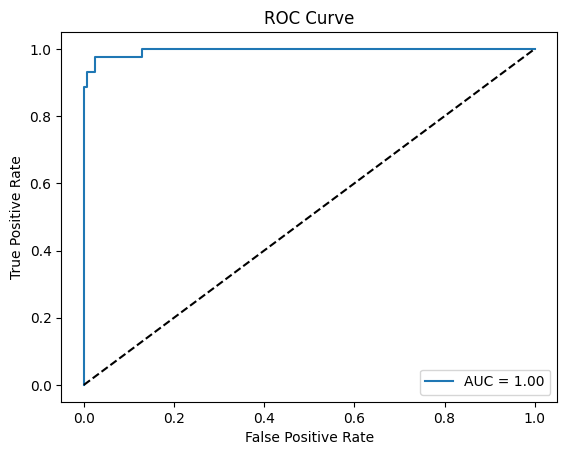

In [22]:
from sklearn.metrics import roc_curve, auc

# Get probability scores
y_prob = svm.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label="AUC = %.2f" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [25]:
joblib.dump(model, "parkinsons_mri_model.pkl")

['parkinsons_mri_model.pkl']